In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2015,2016,2017 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause


# Advanced Sounding Plot with Complex Layout

This example combines simple MetPy plotting functionality, `metpy.calc`
computation functionality, and a few basic Matplotlib tricks to create
an advanced sounding plot with a complex layout & high readability.

In [3]:
# First let's start with some simple imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

Upper air data can easily be obtained using the siphon package,
but for this example we will use some of MetPy's sample data.

In [4]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']
df = pd.read_fwf(get_test_data('may4_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'),
               how='all').reset_index(drop=True)

We will pull the data out of the example dataset into
individual variables and assign units.

In [5]:
p = df['pressure'].values * units.hPa
z = df['height'].values * units.m
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

Now let's make a Skew-T Log-P diagram using some simply
MetPy functionality
Create a new figure. The dimensions here give a good aspect ratio

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


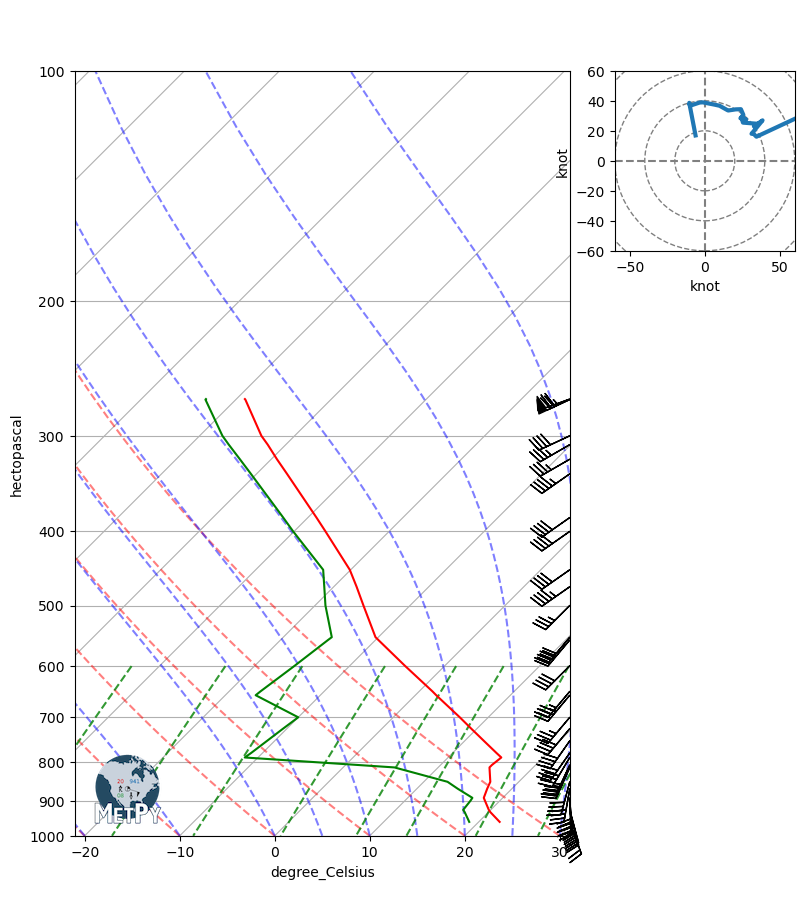

In [6]:
fig = plt.figure(figsize=(9, 9))
add_metpy_logo(fig, 90, 80, size='small')
skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
ax = plt.axes((0.7, 0.75, 0.2, 0.2))
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=20)
h.plot(u, v)

This layout isn't bad, especially for how little code it requires,
but we could add a few simple tricks to greatly increase the
readability and complexity of our Skew-T/Hodograph layout. Let's
try another Skew-T with a few more advanced features:

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


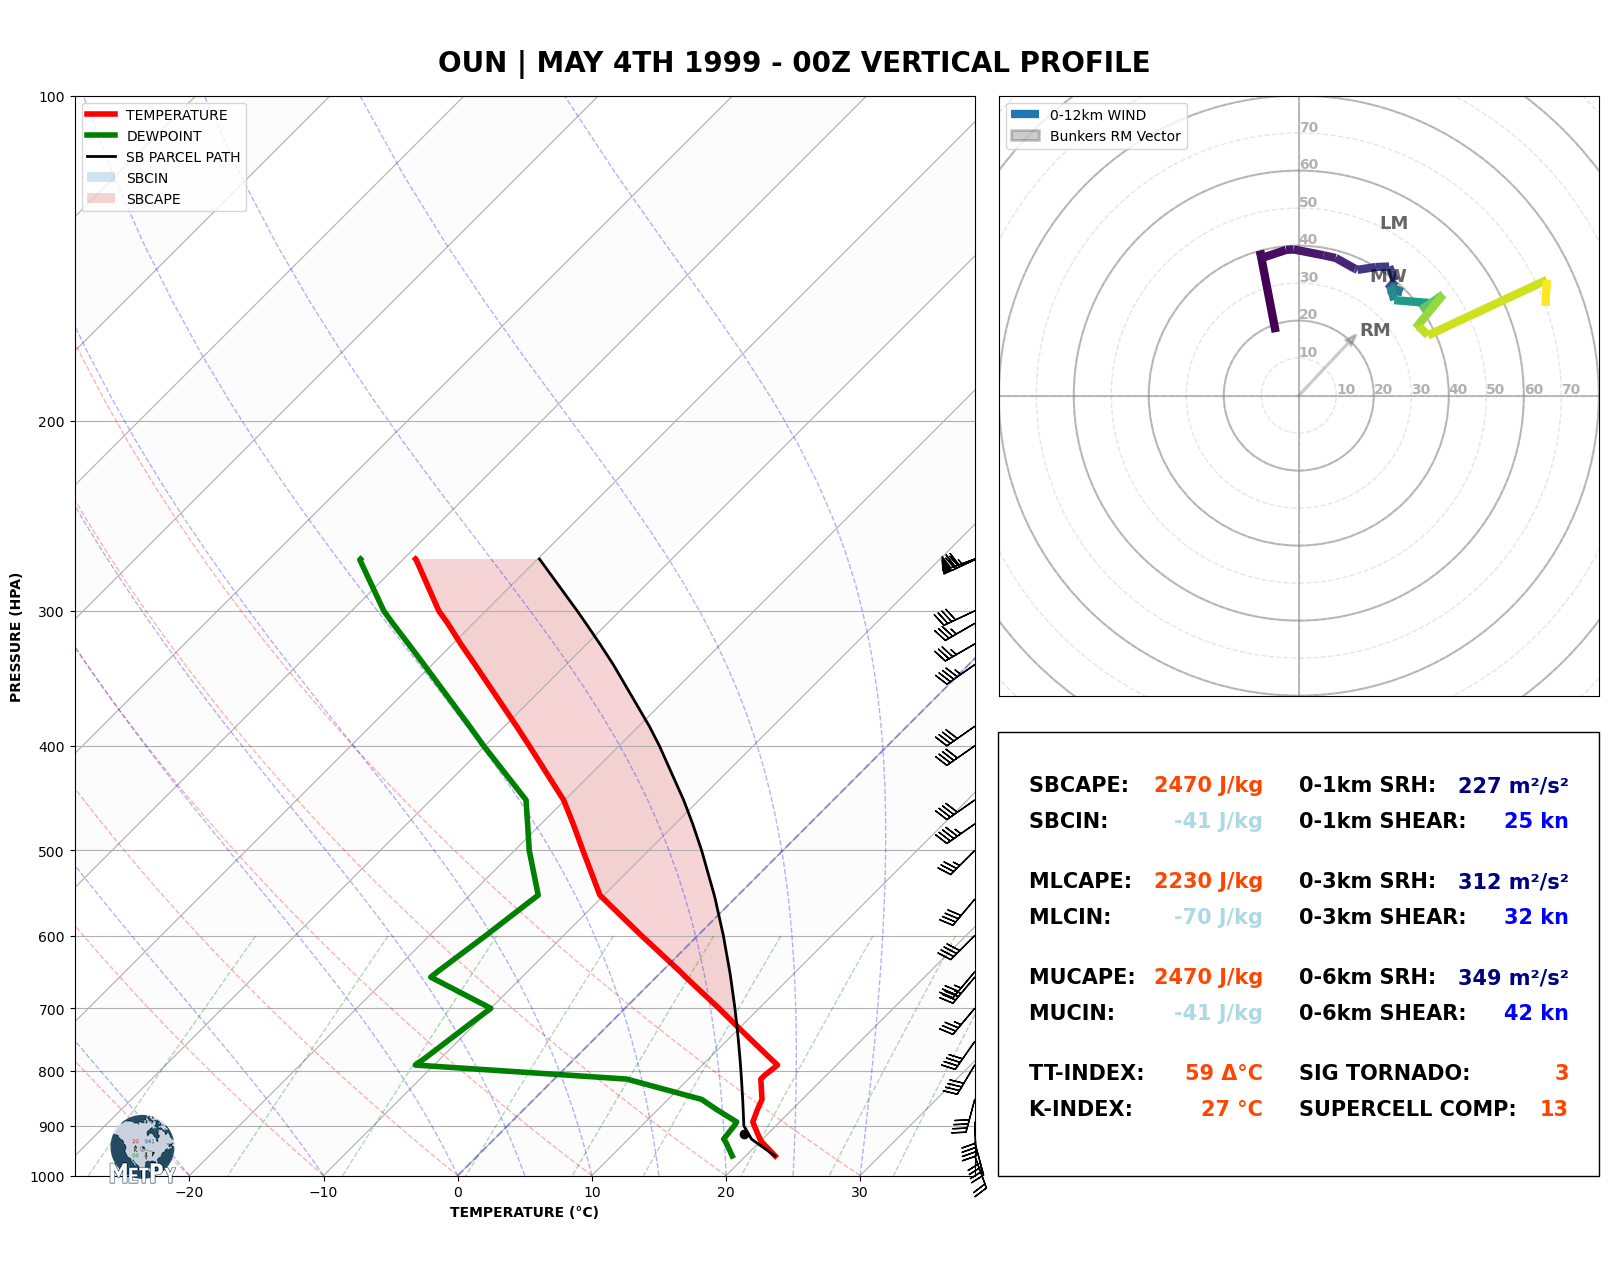

In [7]:
# STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A
# NICE, CLEAN PLOT
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))

# add the Metpy logo
add_metpy_logo(fig, 105, 85, size='small')

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)

# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperature ({T.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressure ({p.units:~P})'), weight='bold')

# Set the facecolor of the skew-t object and the figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and Python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO
# INCREASE READABILITY
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
# Set the linewidth to 4 for increased readability.
# We will also add the 'label' keyword argument for our legend.
skew.plot(p, T, 'r', lw=4, label='TEMPERATURE')
skew.plot(p, Td, 'g', lw=4, label='DEWPOINT')

# Again we can use some simple Python math functionality to 'resample'
# the wind barbs for a cleaner output with increased readability.
# Something like this would work.
interval = np.logspace(2, 3, 40) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first, we add a matplotlib axvline to highlight the 0-degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculate LCL height and plot as a black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from a low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='SB PARCEL PATH')

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# STEP 3: CREATE THE HODOGRAPH INSET. TAKE A FEW EXTRA STEPS TO
# INCREASE READABILITY
# Create a hodograph object: first we need to add an axis
# then we can create the Metpy Hodograph
hodo_ax = plt.axes((0.48, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)

# Add two separate grid increments for a cooler look. This also
# helps to increase readability
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)

# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)

# plot the hodograph itself, using plot_colormapped, colored
# by height
h.plot_colormapped(u, v, c=z, linewidth=6, label='0-12km WIND')
# compute Bunkers storm motion so we can plot it on the hodograph!
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left',
          fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left',
          fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left',
          fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black',
           alpha=0.2, label='Bunkers RM Vector',
           length_includes_head=True, head_width=2)

# STEP 4: ADD A FEW EXTRA ELEMENTS TO REALLY MAKE A NEAT PLOT
# First we want to actually add values of data to the plot for easy viewing
# To do this, let's first add a simple rectangle using Matplotlib's 'patches'
# functionality to add some simple layout for plotting calculated parameters
#                                  xloc   yloc   xsize  ysize
fig.patches.extend([plt.Rectangle((0.563, 0.05), 0.334, 0.37,
                                  edgecolor='black', facecolor='white',
                                  linewidth=1, alpha=1, transform=fig.transFigure,
                                  figure=fig)])

# Now let's take a moment to calculate some simple severe-weather parameters using
# metpy's calculations
# Here are some classic severe parameters!
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)

# mixed layer parcel properties!
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)

# most unstable parcel properties!
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

# Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

# Compute Surface-based CAPE
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
# Compute SRH
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)

# Copmute Bulk Shear components and then magnitude
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

# Use all computed pieces to calculate the Significant Tornado parameter
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                     total_helicity3, bshear3).to_base_units()

# Perform the calculation of supercell composite if an effective layer exists
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# There is a lot we can do with this data operationally, so let's plot some of
# these values right on the plot, in the box we made
# First lets plot some thermodynamic parameters
plt.figtext(0.58, 0.37, 'SBCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.37, f'{sbcape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.34, 'SBCIN: ', weight='bold',
            fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.34, f'{sbcin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.29, 'MLCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.29, f'{mlcape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.26, 'MLCIN: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.26, f'{mlcin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.21, 'MUCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.21, f'{mucape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.18, 'MUCIN: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.18, f'{mucin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.13, 'TT-INDEX: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.13, f'{total_totals:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.10, 'K-INDEX: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.10, f'{kindex:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')

# now some kinematic parameters
plt.figtext(0.73, 0.37, '0-1km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.37, f'{total_helicity1:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.34, '0-1km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.34, f'{bshear1:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.29, '0-3km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.29, f'{total_helicity3:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.26, '0-3km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.26, f'{bshear3:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.21, '0-6km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.21, f'{total_helicity6:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.18, '0-6km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.18, f'{bshear6:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.13, 'SIG TORNADO: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.13, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=15,
            color='orangered', ha='right')
plt.figtext(0.73, 0.10, 'SUPERCELL COMP: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.10, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=15,
            color='orangered', ha='right')

# Add legends to the skew and hodo
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# add a quick plot title, this could be automated by
# declaring a station and datetime variable when using
# realtime observation data from Siphon.
plt.figtext(0.45, 0.97, 'OUN | MAY 4TH 1999 - 00Z VERTICAL PROFILE',
            weight='bold', fontsize=20, ha='center')

# Show the plot
plt.show()